# Fine Tuning Flux Dev/Schnell on NVidia RTX 4090

Presentation by Karim Lalani for AIMUG - Austin LangChain Meetup Group

## Clone AI Toolkit repo by OSTRIS from Github

In [1]:
%%bash
git clone https://github.com/ostris/ai-toolkit.git

Cloning into 'ai-toolkit'...


## cd into workspace

In [2]:
%cd ai-toolkit

/home/karim/Jupyter/AIMUG/ai-toolkit


/home/karim/Jupyter/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Get source code for all submodules dependencies

In [3]:
%%bash
git submodule update --init --recursive

Submodule 'repositories/batch_annotator' (https://github.com/ostris/batch-annotator) registered for path 'repositories/batch_annotator'
Submodule 'repositories/ipadapter' (https://github.com/tencent-ailab/IP-Adapter.git) registered for path 'repositories/ipadapter'
Submodule 'repositories/leco' (https://github.com/p1atdev/LECO) registered for path 'repositories/leco'
Submodule 'repositories/sd-scripts' (https://github.com/kohya-ss/sd-scripts.git) registered for path 'repositories/sd-scripts'
Cloning into '/home/karim/Jupyter/AIMUG/ai-toolkit/repositories/batch_annotator'...
Cloning into '/home/karim/Jupyter/AIMUG/ai-toolkit/repositories/ipadapter'...
Cloning into '/home/karim/Jupyter/AIMUG/ai-toolkit/repositories/leco'...
Cloning into '/home/karim/Jupyter/AIMUG/ai-toolkit/repositories/sd-scripts'...


Submodule path 'repositories/batch_annotator': checked out '420e142f6ad3cc14b3ea0500affc2c6c7e7544bf'


Submodule 'repositories/controlnet' (https://github.com/lllyasviel/ControlNet-v1-1-nightly.git) registered for path 'repositories/batch_annotator/repositories/controlnet'
Cloning into '/home/karim/Jupyter/AIMUG/ai-toolkit/repositories/batch_annotator/repositories/controlnet'...


Submodule path 'repositories/batch_annotator/repositories/controlnet': checked out 'e2b44154b72965c5e11b1ccee941d550682e4701'
Submodule path 'repositories/ipadapter': checked out '5a18b1f3660acaf8bee8250692d6fb3548a19b14'
Submodule path 'repositories/leco': checked out '9294adf40218e917df4516737afb13f069a6789d'
Submodule path 'repositories/sd-scripts': checked out '25f961bc779bc79aef440813e3e8e92244ac5739'


## Install UV 

In [4]:
%pip install uv

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### List available Python runtimes. We need version 3.10.12. Required version of pytorch doesn't seem to like newer version of Python.

In [5]:
%%bash
uv python list

cpython-3.14.0a4+freethreaded-linux-x86_64-gnu    <download available>
cpython-3.14.0a4-linux-x86_64-gnu                 <download available>
cpython-3.13.1+freethreaded-linux-x86_64-gnu      /home/karim/.local/share/uv/python/cpython-3.13.1+freethreaded-linux-x86_64-gnu/bin/python3.13t
cpython-3.13.1-linux-x86_64-gnu                   /usr/bin/python3.13
cpython-3.13.1-linux-x86_64-gnu                   /bin/python3.13
cpython-3.13.1-linux-x86_64-gnu                   /home/karim/.local/share/uv/python/cpython-3.13.1-linux-x86_64-gnu/bin/python3.13
cpython-3.12.8-linux-x86_64-gnu                   /usr/bin/python3.12
cpython-3.12.8-linux-x86_64-gnu                   /bin/python3.12
cpython-3.12.8-linux-x86_64-gnu                   <download available>
cpython-3.11.11-linux-x86_64-gnu                  /usr/bin/python3.11
cpython-3.11.11-linux-x86_64-gnu                  /bin/python3.11
cpython-3.11.11-linux-x86_64-gnu                  <download available>
cpython-3.10.16-linux-x86_64-g

### Install and pin Python 3.10.12

In [21]:
%%bash
uv python install cpython-3.10.12-linux-x86_64-gnu
uv python pin cpython-3.10.12-linux-x86_64-gnu

Installed Python 3.10.12 in 990ms
 + cpython-3.10.12-linux-x86_64-gnu


Pinned `.python-version` to `cpython-3.10.12-linux-x86_64-gnu`


## Create a new virtual environment for AI-Toolkit

We use `uv venv` to initialize a new virtual environment. After activating it, we install `torch` and other dependencies from `requirements.txt`.

Note: There is a bug in the latest code of `diffusers` that causes ai-toolkit to crash at the beginning of finetuning.  
So we reinstall `diffusers` to grab the latest released version instead.  
See [this github issue and comment](https://github.com/ostris/ai-toolkit/issues/243#issuecomment-2618692497) for more details.

In [7]:
%%bash
uv venv
source .venv/bin/activate
uv pip install torch
uv pip install -r requirements.txt
uv pip uninstall diffusers
uv pip install diffusers

Using CPython 3.10.12 interpreter at: /usr/bin/python3.10
Creating virtual environment at: .venv
Activate with: source .venv/bin/activate
Resolved 23 packages in 107ms
Installed 23 packages in 110ms
 + filelock==3.17.0
 + fsspec==2025.2.0
 + jinja2==3.1.5
 + markupsafe==3.0.2
 + mpmath==1.3.0
 + networkx==3.4.2
 + nvidia-cublas-cu12==12.4.5.8
 + nvidia-cuda-cupti-cu12==12.4.127
 + nvidia-cuda-nvrtc-cu12==12.4.127
 + nvidia-cuda-runtime-cu12==12.4.127
 + nvidia-cudnn-cu12==9.1.0.70
 + nvidia-cufft-cu12==11.2.1.3
 + nvidia-curand-cu12==10.3.5.147
 + nvidia-cusolver-cu12==11.6.1.9
 + nvidia-cusparse-cu12==12.3.1.170
 + nvidia-cusparselt-cu12==0.6.2
 + nvidia-nccl-cu12==2.21.5
 + nvidia-nvjitlink-cu12==12.4.127
 + nvidia-nvtx-cu12==12.4.127
 + sympy==1.13.1
 + torch==2.6.0
 + triton==3.2.0
 + typing-extensions==4.12.2
Resolved 147 packages in 673ms
Uninstalled 1 package in 0.63ms
Installed 125 packages in 62ms
 + absl-py==2.1.0
 + accelerate==1.3.0
 + aiofiles==23.2.1
 + albucore==0.0.16
 

## Bring your Huggingface token

AI-Toolkit downloads the **Flux** models from Huggingface. **Flux Dev** model requires you to agree to their TOS here [https://huggingface.co/black-forest-labs/FLUX.1-dev](https://huggingface.co/black-forest-labs/FLUX.1-dev) before you can get access to the weights. Once you approve to the TOS on Huggingface, you will need a token with **READ** permissions from here [https://huggingface.co/settings/tokens/new?](https://huggingface.co/settings/tokens/new?). Once you have you **READ** token, save it within `.env` file as `HF_TOKEN`.

In [8]:
import getpass

hf_token = getpass.getpass("Enter Read token from Huggingface.co")

Enter Read token from Huggingface.co ········


In [9]:
!echo "HF_TOKEN=$hf_token" > .env

## Launch Gradio UI for Flux Finetuning

The below cell will launch the Gradio UI. 

Once there do the following:  
1. Provide a locally unique name for your LoRA finetune.
2. Provide a trigger word or phrase to activate your LoRA finetune.
3. Upload around 30 photos.
4. Provide captions for each image. Include `[trigger]` as a placeholder for your activation trigger word or phrase.
6. Optionally, you can click **Add AI Captions with Florence-2** and have `Florence-2` model generate captions for you.
   - This will download the **Florence-2** model and generate captions for your uploaded photos.
8. Scroll to the bottom of the page and provide 3 test prompts. These will be used to generate sample images using Flux model and the finetuned LoRA.
9. Optionally, under the **Advanced Settings**, you can change which **Flux** model to finetune, and whether to run the finetuning in **low VRAM** mode or not. Defaults are **Dev** model and **Yes** on **low VRAM**.
10. Once ready, click **Start Training** to start the finetuning.
    - This will first download the selected model weights, and then start training on your photos and provided captions.
    - After the training is complete, the 3 provided test prompts will be used to generate images.
    - The finetune can be found under `output/<LoRA name provided in step 1>/<LoRA name>.safetensors`.
    - Sample images can be found under a subfolder there called `samples`.
    - The training should take around 30 to 40 minutes.
    - Once you see a message like `Saved to output/<LoRA name>/optimizer.pt`, you can stop the cell execution and continue with the remaining cells to see the sample images.

In [10]:
!source .venv/bin/activate && uv run flux_train_ui.py

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://e8f4ff4a46de67c1ed.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
20140112_171743
/tmp/gradio/39df87a65e3995b400dcfc1610b41dfe7795a8f7e03a9a32324557715cfbcd62/20140112_171743.jpg
20140116_163222
/tmp/gradio/8c7a1dd72b21aec4807d66f23c588a40605a9ca137d55160f807e3a09ce07c6b/20140116_163222.jpg
20160926_092431_HDR
/tmp/gradio/2fad929e7afd494862f0b9b9487aa7ca009b56f72557bc3c12f9781b87c25b1c/20160926_092431_HDR.jpg
20161130_224647_HDR
/tmp/gradio/2e50e2ebaf9912b14744204358249b6972e859a20c5d5d8765a709667fba762d/20161130_224647_HDR.jpg
20161227_170641_HDR
/tmp/gradio/baf174a504761be846249b49398b817bb71dbabdee3399a70aa099c90328bbfe/20161227_170641_HDR.jpg
20170108_142527_HDR
/tmp/gradio/4c99682b9f9423095f692247d693b2b627fb6a1763df509941a5f02f4

## Viewing the generated Sample images

### `cd` into the samples folder. 

In [15]:
%cd output/karim-lalani/samples

/home/karim/Jupyter/AIMUG/ai-toolkit/output/karim-lalani/samples


/home/karim/Jupyter/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Import necessary packages to list directory contents and display images within jupyter notebook.

In [16]:
from IPython.display import Image
import os

### Gather the three generated sample image files

In [17]:
[sample1,sample2,sample3] = os.listdir('.')

### Display the sample images

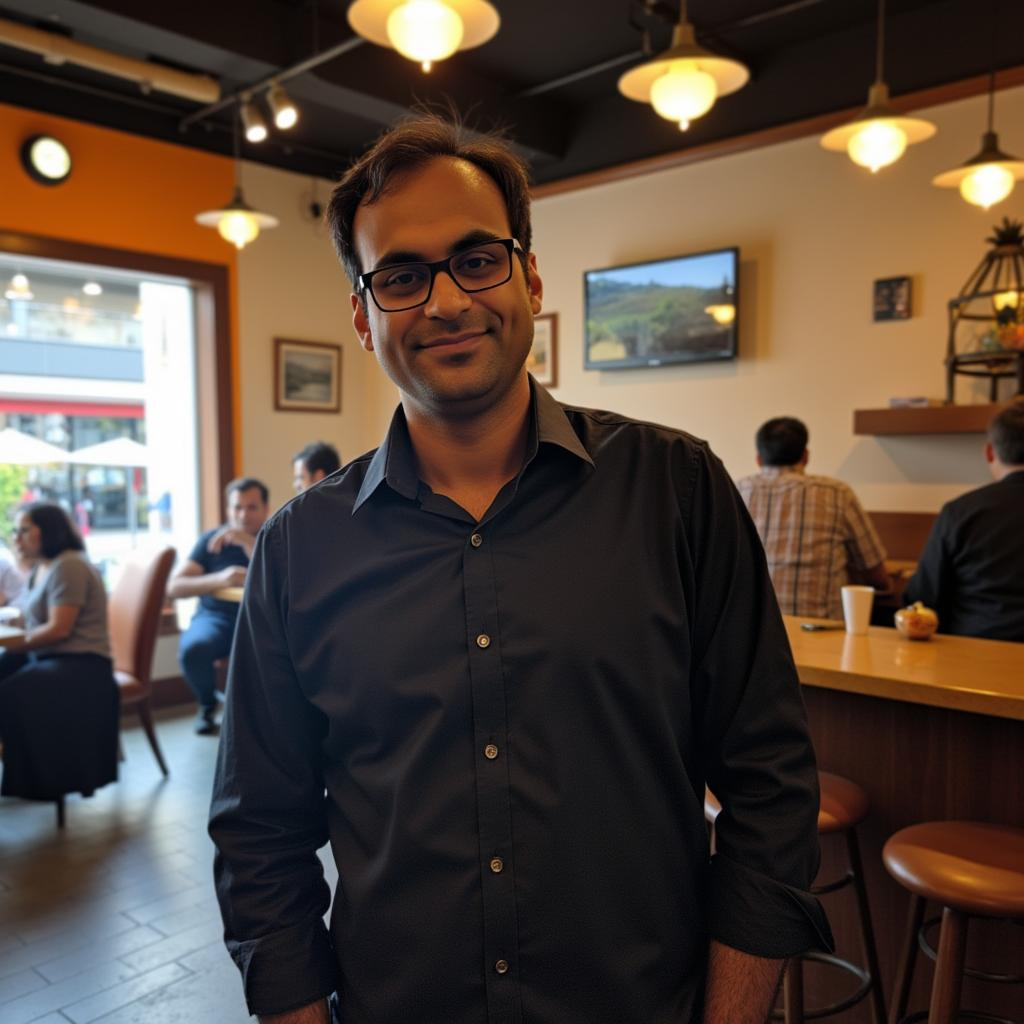

In [18]:
Image(sample1)

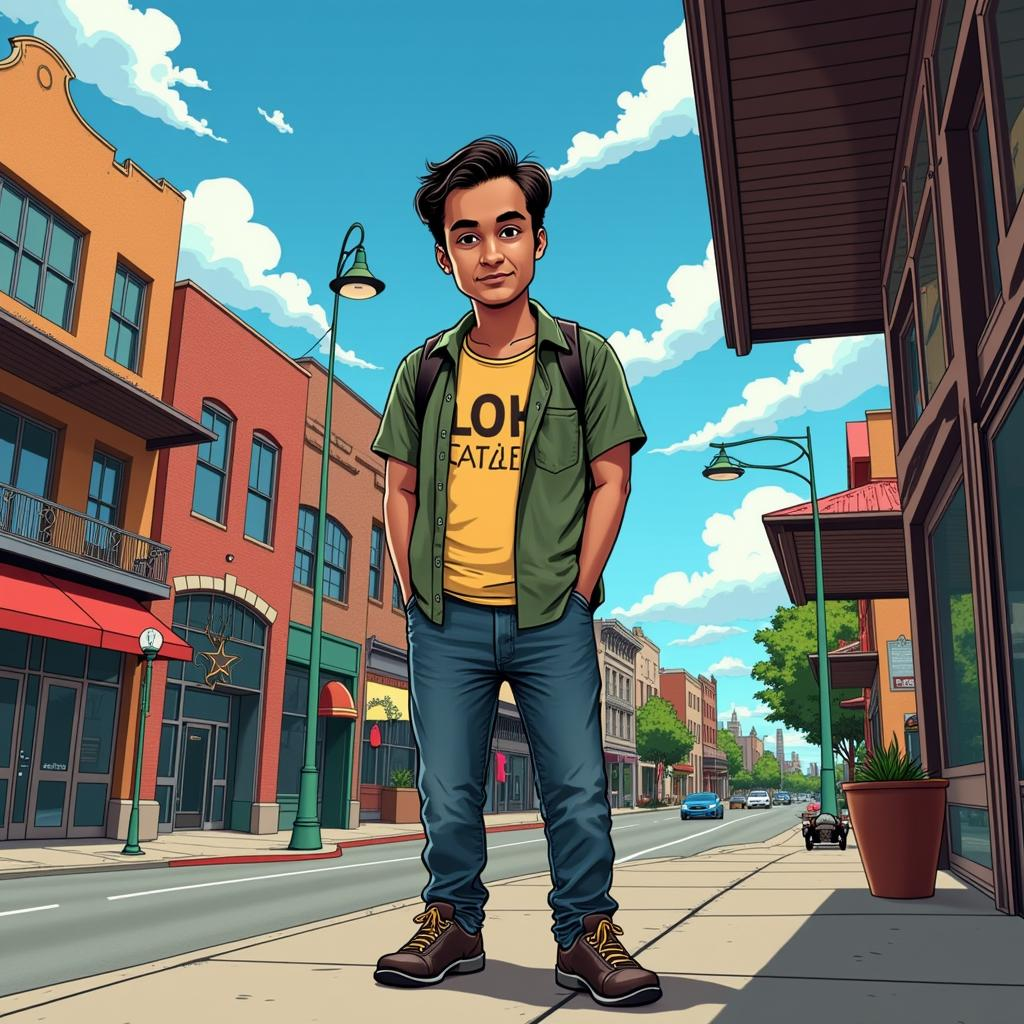

In [19]:
Image(sample2)

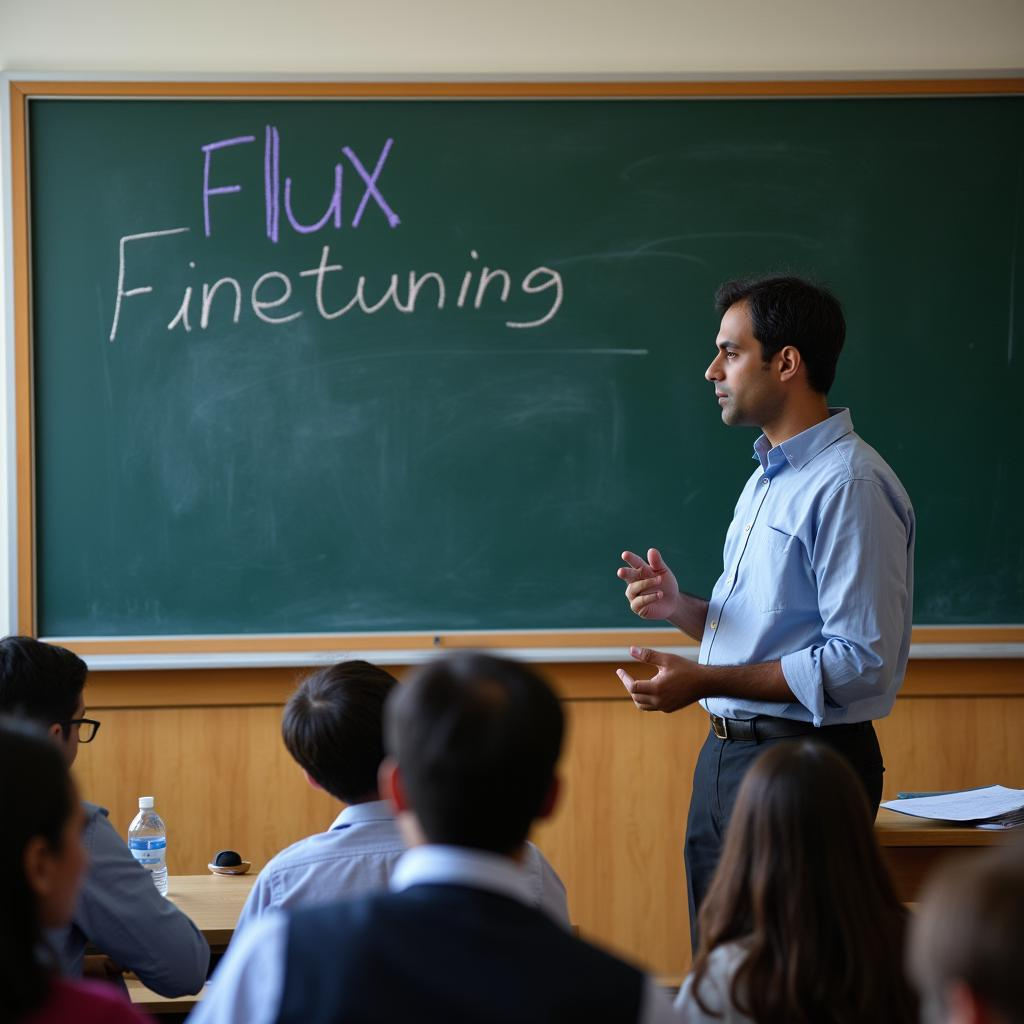

In [20]:
Image(sample3)

# Additional resources

1. [Flux.1 ComfyUI install guidance, workflow and example on Comfyui-Wiki](https://comfyui-wiki.com/en/tutorial/advanced/flux1-comfyui-guide-workflow-and-examples)
2. [How to use Flux LoRA on ComfyUI on Stable Diffusion Art](https://stable-diffusion-art.com/flux-lora-comfyui/)
3. [FLUX + LORA (simple) on OpenART Workflows](https://openart.ai/workflows/ailab/flux-lora-simple/gErKNyjsnetZpEgaMTrV)